In [1]:
import torch
import pathlib
import cv2
import PIL
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
%matplotlib inline

from passion.segmentation import prediction

In [2]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
models_folder_path = pathlib.Path('../../workflow/output/model')
old_rooftop_models_folder_path = models_folder_path / 'old-rooftop-segmentation'
rooftop_models_folder_path = models_folder_path / 'rooftop-segmentation'
section_models_folder_path = models_folder_path / 'section-segmentation'

# Sections model
model_rid_final = torch.load(str(section_models_folder_path / 'sections-mix-aug-20e.pth'), map_location=torch.device(device))

# Rooftop model
model_inria_final = torch.load(str(rooftop_models_folder_path / 'inria-aug-12e.pth'), map_location=torch.device(device))

In [4]:
rid_test_folder = pathlib.Path('/storage/internal/home/r-pueblas/projects/rooftop-segmentation-datasets/data/RID/output/masks_segments_reviewed/test')
rid_test_folder_image = rid_test_folder / 'image'
rid_test_folder_label = rid_test_folder / 'label'

In [5]:
def intersect_and_union(pred_label, label, num_classes, ignore_index):
    mask = (label != ignore_index)
    pred_label = pred_label[mask]
    label = label[mask]

    intersect = pred_label[pred_label == label]
    area_intersect, _ = np.histogram(
        intersect, bins=np.arange(num_classes + 1))
    area_pred_label, _ = np.histogram(
        pred_label, bins=np.arange(num_classes + 1))
    area_label, _ = np.histogram(label, bins=np.arange(num_classes + 1))
    area_union = area_pred_label + area_label - area_intersect

    return area_intersect, area_union, area_pred_label, area_label

def angle_difference(angle_1, angle_2):
    a = angle_1 - angle_2
    a = (a + 180) % 360 - 180
    return a

def mean_angle_difference(pred_label, label, num_classes, angles, background_class, ignore_index):
    mask = (label != ignore_index)
    pred_label = pred_label[mask]
    label = label[mask]
    
    combined_pred_label = (pred_label != background_class).astype('uint8')
    combined_label = (label != background_class).astype('uint8')
    
    # Take those pixels where both images predict a class different than background
    pred_label_angles = pred_label[combined_pred_label == combined_label]
    pred_label_angles = pred_label_angles[pred_label_angles < len(angles)]
    label_angles = label[combined_pred_label == combined_label]
    label_angles = label_angles[label_angles < len(angles)]
    
    
    total_diff = 0
    for angle_1, angle_2 in zip(np.nditer(pred_label_angles, flags=['zerosize_ok']), np.nditer(label_angles, flags=['zerosize_ok'])):
        try:
            angle_1, angle_2 = angles[angle_1], angles[angle_2]
        except:
            print(angle_1, angle_2)
        diff = angle_difference(angle_1, angle_2)
        total_diff = total_diff + diff
    
    if pred_label_angles.size == 0:
        return None
    
    mean_diff = total_diff/pred_label_angles.size
    
    return mean_diff

In [23]:
def test_model_sections(model, test_folder, num_classes, background_class, ignore_index, num_angles, output=True, num_samples=15):
    start = time.time()
    
    test_folder_image = test_folder / 'image'
    test_folder_label = test_folder / 'label'

    angles = [i * (360/num_angles) for i in range(num_angles)]

    total_area_intersect = np.zeros((num_classes, ), dtype=float)
    total_area_union = np.zeros((num_classes, ), dtype=float)
    total_area_pred_label = np.zeros((num_classes, ), dtype=float)
    total_area_label = np.zeros((num_classes, ), dtype=float)
    total_angle_difference = 0

    for i, filename in enumerate(test_folder_image.glob('*.png')):
        if i>num_samples: break
        image = cv2.imread(str(filename))
        label = cv2.imread(str(test_folder_label / filename.name))
        label = label[:,:,0]


        pred = prediction.segment_img(image, model, tile_size=512, stride=512, background_class=background_class)
        corrected_pred = pred.copy()
        corrected_pred[pred==0] = (background_class + 1)
        corrected_pred = (corrected_pred - 1)

        area_intersect, area_union, area_pred_label, area_label = \
                            intersect_and_union(corrected_pred, label, num_classes, ignore_index)
        total_area_intersect += area_intersect
        total_area_union += area_union
        total_area_pred_label += area_pred_label
        total_area_label += area_label

        mad = mean_angle_difference(corrected_pred, label, num_classes, angles, background_class, ignore_index)
        if mad: total_angle_difference += mad

        if output:
            f, axarr = plt.subplots(1,3, figsize=(10, 10))
            axarr[0].imshow(image)
            axarr[1].imshow(label)
            axarr[2].imshow(corrected_pred)

            plt.subplots_adjust(wspace=0.1, hspace=0.1)
            for ax in axarr:
                ax.axis('off')
            plt.show()

        iou = total_area_intersect / total_area_union

        if output: print(f'Processed image {filename.stem}, partial mean iou: {np.mean(iou[:-1][~np.isnan(iou[:-1])])}, with background class: {np.mean(iou[~np.isnan(iou)])}, mean angle difference: {mad}')

    all_acc = total_area_intersect.sum() / total_area_label.sum()
    acc = total_area_intersect / total_area_label
    iou = total_area_intersect / total_area_union
    mad = total_angle_difference / (i+1)

    end = time.time()
    elapsed_time = (end - start)

    if output:
        print('\n')
        print(f'Elapsed time: {elapsed_time} seconds')
        print(f'Final IoU per class: {iou}')
        print(f'Final mean IoU with background class: {np.mean(iou[~np.isnan(iou)])}')
        print(f'Final mean IoU without background class: {np.mean(iou[:-1][~np.isnan(iou[:-1])])}')
        print(f'Final mean angle difference: {mad}')

    return iou, np.mean(iou[~np.isnan(iou)]), mad, elapsed_time

def test_model_twolook(rooftop_model,
                       sections_model,
                       test_folder,
                       num_classes,
                       background_class_1,
                       background_class_2,
                       ignore_index,
                       num_angles,
                       output=True,
                       num_samples=15
                      ):
    start = time.time()
    
    test_folder_image = test_folder / 'image'
    test_folder_label = test_folder / 'label'

    angles = [i * (360/num_angles) for i in range(num_angles)]

    total_area_intersect = np.zeros((num_classes, ), dtype=float)
    total_area_union = np.zeros((num_classes, ), dtype=float)
    total_area_pred_label = np.zeros((num_classes, ), dtype=float)
    total_area_label = np.zeros((num_classes, ), dtype=float)
    total_angle_difference = 0

    for i, filename in enumerate(test_folder_image.glob('*.png')):
        if i>num_samples: break
        image = cv2.imread(str(filename))
        label = cv2.imread(str(test_folder_label / filename.name))
        label = label[:,:,0]
    
        roofs = prediction.segment_img(image, rooftop_model, tile_size=512, stride=512, background_class=background_class_1)
        filtered = np.ones(image.shape).astype(np.uint8)
        idx=(roofs!=0)
        filtered[idx] = image[idx]

        pred = prediction.segment_img(image, sections_model, tile_size=512, stride=512, background_class=background_class_2)
        unfiltered_pred = pred.copy()
        unfiltered_pred[pred==0] = (background_class + 1)
        unfiltered_pred = (unfiltered_pred - 1)
        
        pred = (pred * idx.astype('uint8'))
        corrected_pred = pred.copy()
        corrected_pred[pred==0] = (background_class + 1)
        corrected_pred = (corrected_pred - 1)

        area_intersect, area_union, area_pred_label, area_label = \
                            intersect_and_union(corrected_pred, label, num_classes, ignore_index)
        total_area_intersect += area_intersect
        total_area_union += area_union
        total_area_pred_label += area_pred_label
        total_area_label += area_label

        mad = mean_angle_difference(corrected_pred, label, num_classes, angles, background_class, ignore_index)
        if mad: total_angle_difference += mad

        if output:
            f, axarr = plt.subplots(1,4, figsize=(10, 10))
            axarr[0].imshow(image)
            axarr[1].imshow(roofs)
            axarr[2].imshow(unfiltered_pred)
            axarr[3].imshow(corrected_pred)

            plt.subplots_adjust(wspace=0.1, hspace=0.1)
            for ax in axarr:
                ax.axis('off')
            plt.show()

        iou = total_area_intersect / total_area_union

        if output: print(f'Processed image {filename.stem}, partial mean iou: {np.mean(iou[:-1][~np.isnan(iou[:-1])])}, with background class: {np.mean(iou[~np.isnan(iou)])}, mean angle difference: {mad}')

    all_acc = total_area_intersect.sum() / total_area_label.sum()
    acc = total_area_intersect / total_area_label
    iou = total_area_intersect / total_area_union
    mad = total_angle_difference / (i+1)

    end = time.time()
    elapsed_time = (end - start)

    if output:
        print('\n')
        print(f'Elapsed time: {elapsed_time} seconds')
        print(f'Final IoU per class: {iou}')
        print(f'Final mean IoU with background class: {np.mean(iou[~np.isnan(iou)])}')
        print(f'Final mean IoU without background class: {np.mean(iou[:-1][~np.isnan(iou[:-1])])}')
        print(f'Final mean angle difference: {mad}')

    return iou, np.mean(iou[~np.isnan(iou)]), mad, elapsed_time

In [14]:
num_classes = 18
background_class = 17
ignore_index = -1
num_angles = 16

Testing model <model_mix_val19>...


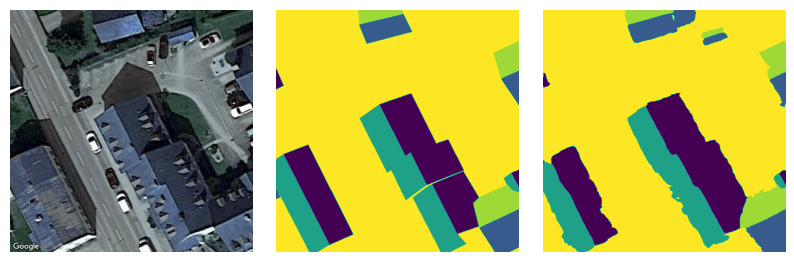

/tmp/ipykernel_1218748/1899510365.py:48: RuntimeWarning: invalid value encountered in true_divide
  iou = total_area_intersect / total_area_union


Processed image 1277, partial mean iou: 0.8263529030512639, with background class: 0.8508607550976363, mean angle difference: -3.89295853188685


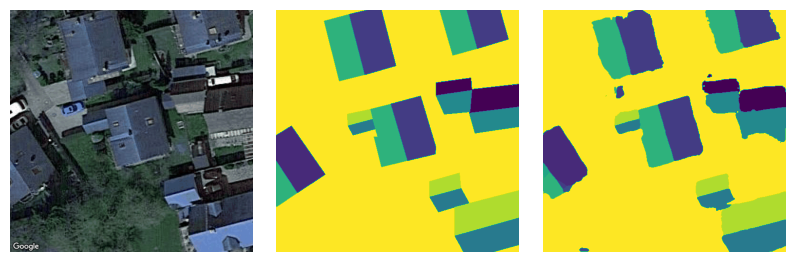

Processed image 1080, partial mean iou: 0.6691303696440087, with background class: 0.6976498410430293, mean angle difference: -2.280192107061913


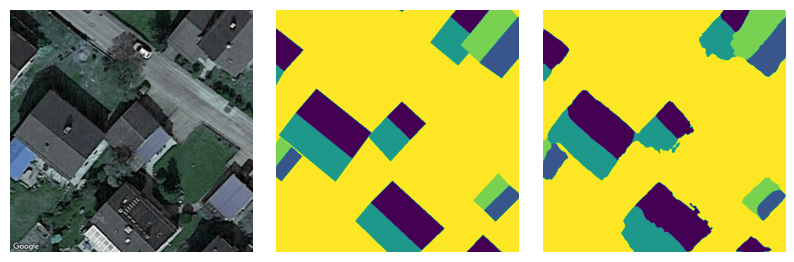

Processed image 785, partial mean iou: 0.7680366473712674, with background class: 0.7839032626564078, mean angle difference: -7.614581440532267


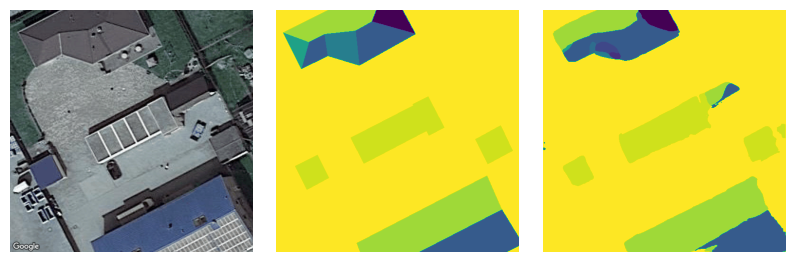

Processed image 1780, partial mean iou: 0.6606260132624182, with background class: 0.6805323802161296, mean angle difference: -5.971304647555581


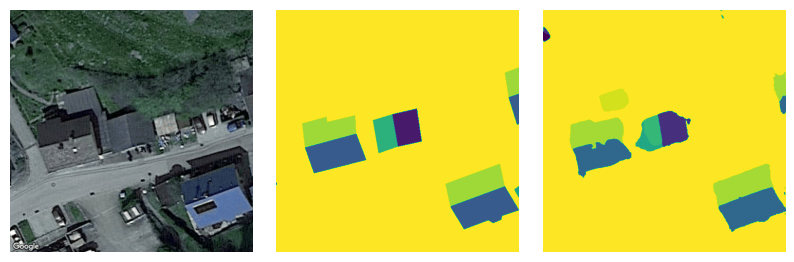

Processed image 1319, partial mean iou: 0.6996758260942545, with background class: 0.7161077866769998, mean angle difference: -6.7565639726861795


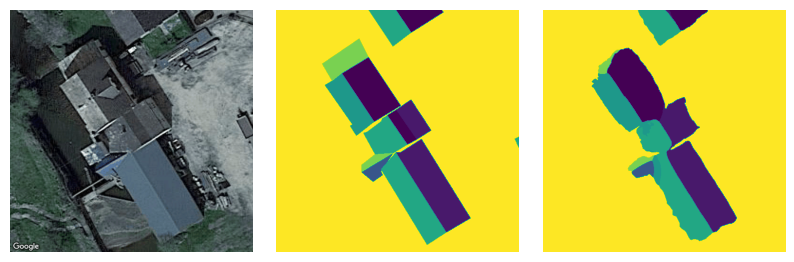

Processed image 1719, partial mean iou: 0.6816969468438394, with background class: 0.6993531391245863, mean angle difference: -0.07008537148131057


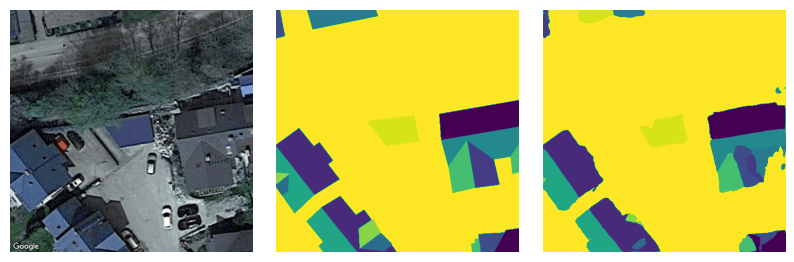

Processed image 1232, partial mean iou: 0.6335767185191348, with background class: 0.6542617465353832, mean angle difference: -32.836767617511185


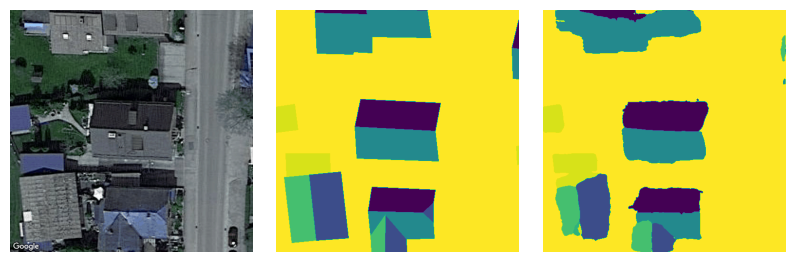

Processed image 1141, partial mean iou: 0.645536760660051, with background class: 0.665245678875701, mean angle difference: -18.39973829076798


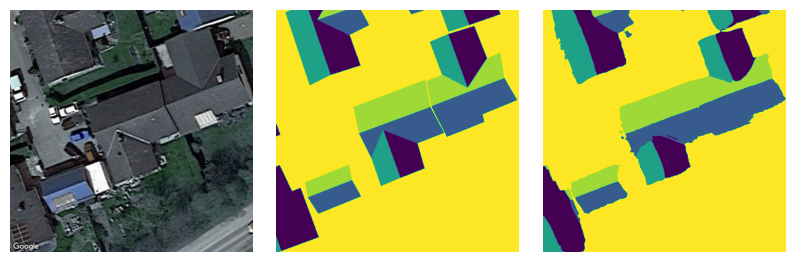

Processed image 1782, partial mean iou: 0.64737982869667, with background class: 0.6669877967365918, mean angle difference: -4.592456736503364


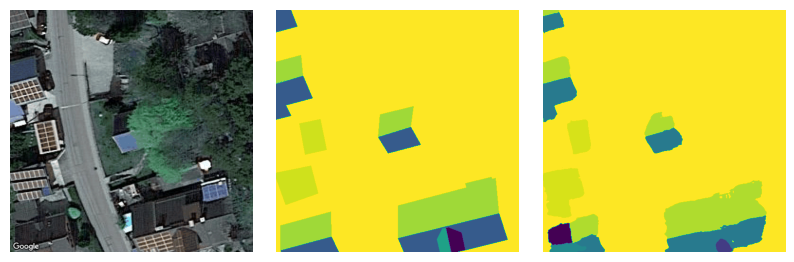

Processed image 1329, partial mean iou: 0.6402392821312611, with background class: 0.6602940827451471, mean angle difference: -9.759655315614618


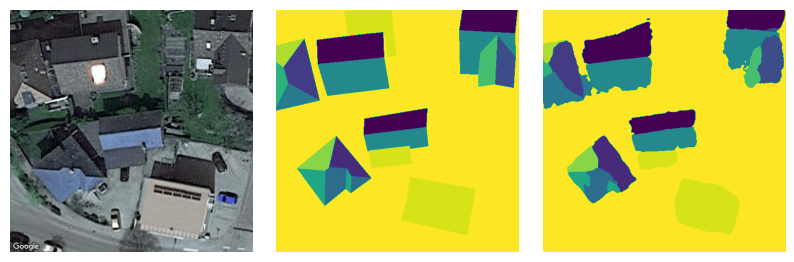

Processed image 1515, partial mean iou: 0.6342760783923762, with background class: 0.6545256243125841, mean angle difference: -14.918462958328119


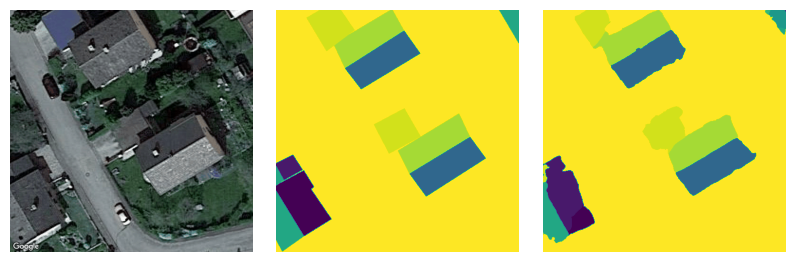

Processed image 52, partial mean iou: 0.6280295278257098, with background class: 0.6487476473640686, mean angle difference: -40.626924557351806


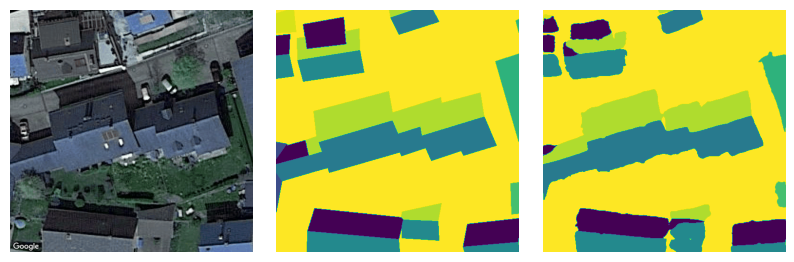

Processed image 1241, partial mean iou: 0.6252468823644339, with background class: 0.6460283084883338, mean angle difference: -31.380391945941188


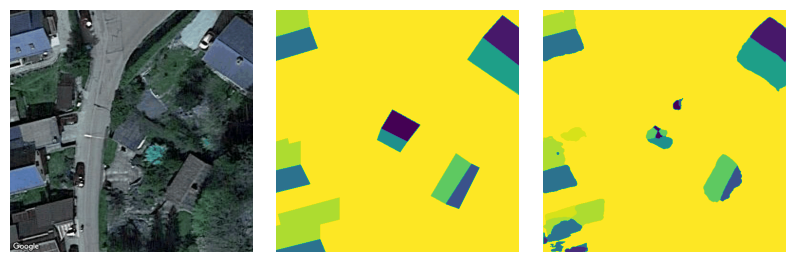

Processed image 1891, partial mean iou: 0.6300503743544392, with background class: 0.6482403841779445, mean angle difference: -16.17435926195951


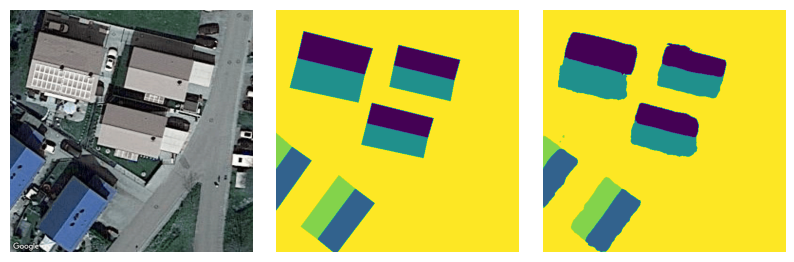

Processed image 302, partial mean iou: 0.7187549987688457, with background class: 0.7321090032737855, mean angle difference: -2.8370574080440014


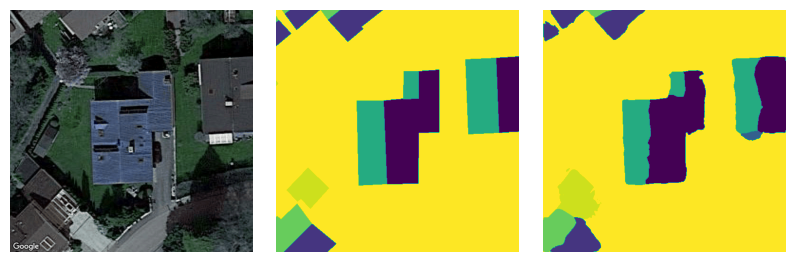

Processed image 475, partial mean iou: 0.7338317485951487, with background class: 0.7463657185475085, mean angle difference: -17.523575590006914


Elapsed time: 13.009521961212158 seconds
Final IoU per class: [0.78871396 0.79062564 0.74359595 0.78775972 0.7202697  0.47178916
 0.77996117 0.7861173  0.75334355 0.75904439 0.75862932 0.7769862
 0.6757503  0.72318841 0.68983056 0.80231424 0.66722016 0.95944321]
Final mean IoU with background class: 0.7463657185475085
Final mean IoU without background class: 0.7338317485951487
Final mean angle difference: -12.6844162207784
Mean IoU: 0.7463657185475085
Mean angle difference: -12.6844162207784 degrees
IoU per class: [0.78871396 0.79062564 0.74359595 0.78775972 0.7202697  0.47178916
 0.77996117 0.7861173  0.75334355 0.75904439 0.75862932 0.7769862
 0.6757503  0.72318841 0.68983056 0.80231424 0.66722016 0.95944321]
Elapsed time: 13.009521961212158 seconds.


In [15]:
iou, mean_iou, mad, elapsed_time = test_model_sections(model_rid_final, rid_test_folder, num_classes, background_class, ignore_index, num_angles, output=True)

print(f'Mean IoU: {mean_iou}')
print(f'Mean angle difference: {mad} degrees')
print(f'IoU per class: {iou}')
print(f'Elapsed time: {elapsed_time} seconds.')

In [16]:
num_classes = 18
background_class_1 = 0
background_class_2 = 17
ignore_index = -1
num_angles = 16

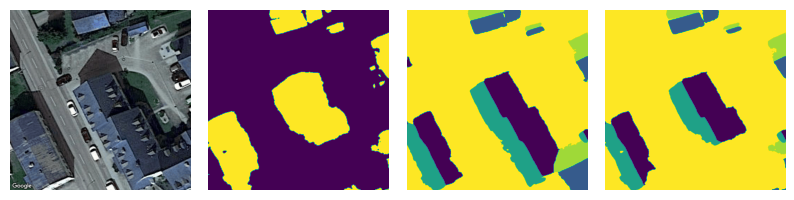

/tmp/ipykernel_1218748/680424873.py:137: RuntimeWarning: invalid value encountered in true_divide
  iou = total_area_intersect / total_area_union


Processed image 1277, partial mean iou: 0.5529061932800844, with background class: 0.6116115011781327, mean angle difference: -4.7272727272727275


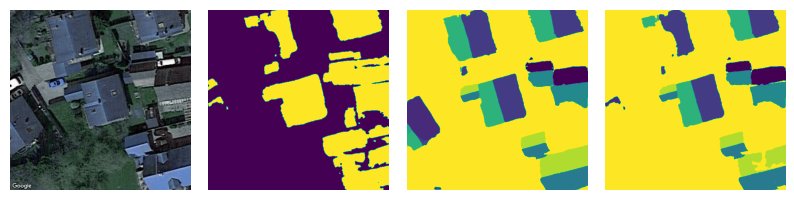

Processed image 1080, partial mean iou: 0.6144568879490422, with background class: 0.6450070593892063, mean angle difference: -2.4166263140630124


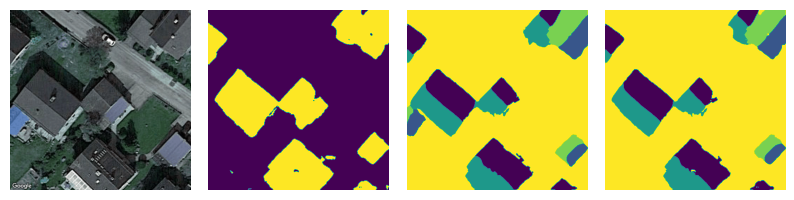

Processed image 785, partial mean iou: 0.7115583466997223, with background class: 0.7273003343517842, mean angle difference: -6.101882273467006


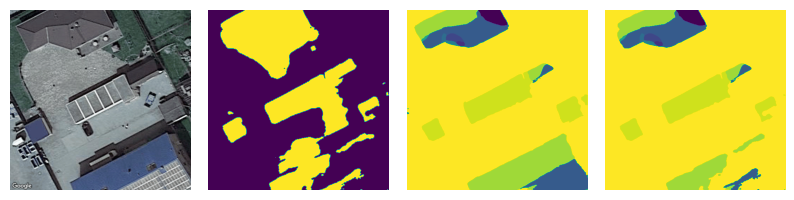

Processed image 1780, partial mean iou: 0.5979247106866084, with background class: 0.6182151624718125, mean angle difference: -7.982118605703938


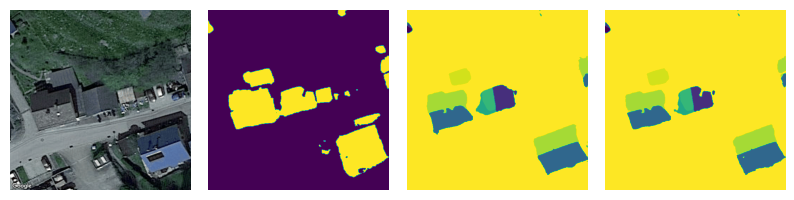

Processed image 1319, partial mean iou: 0.6065087494121417, with background class: 0.6249437670614968, mean angle difference: -6.805331586373715


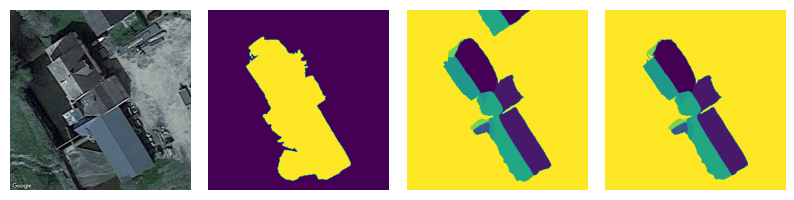

Processed image 1719, partial mean iou: 0.5943833649760882, with background class: 0.6140180521257114, mean angle difference: 1.155509235647604


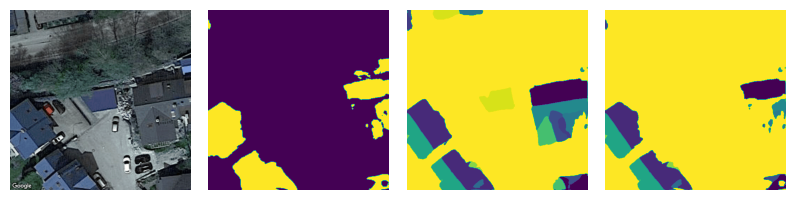

Processed image 1232, partial mean iou: 0.5033168836261804, with background class: 0.5281322127898241, mean angle difference: -2.3229929735386454


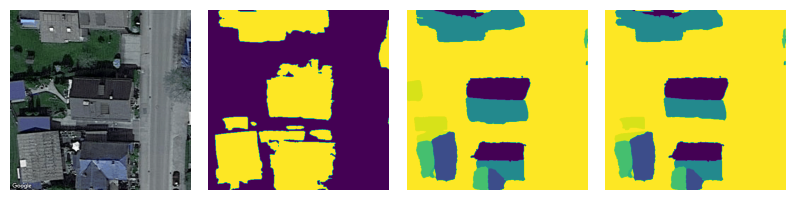

Processed image 1141, partial mean iou: 0.5385524014512495, with background class: 0.5612307923689047, mean angle difference: -17.65970135382137


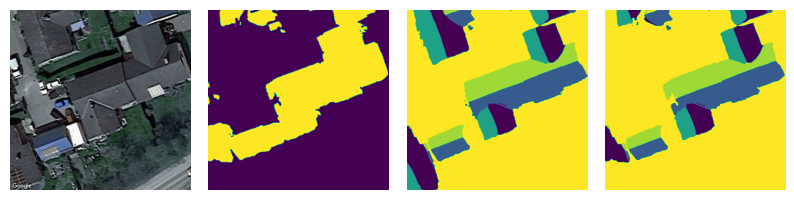

Processed image 1782, partial mean iou: 0.54444311791027, with background class: 0.5666245677185832, mean angle difference: -1.8404377880184333


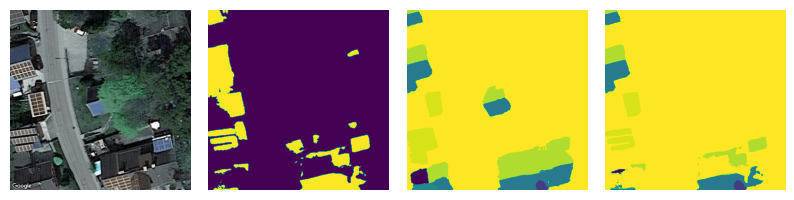

Processed image 1329, partial mean iou: 0.5372397560171317, with background class: 0.5596851525154168, mean angle difference: -7.53348696528878


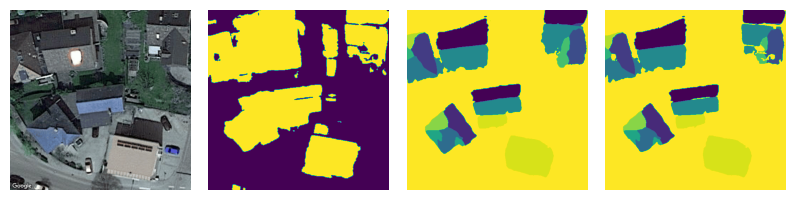

Processed image 1515, partial mean iou: 0.5397483634286552, with background class: 0.5621380674096919, mean angle difference: -20.928642976780846


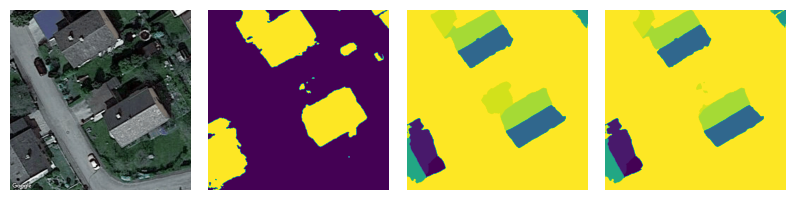

Processed image 52, partial mean iou: 0.5365582739879063, with background class: 0.559417459195986, mean angle difference: -40.40912935970849


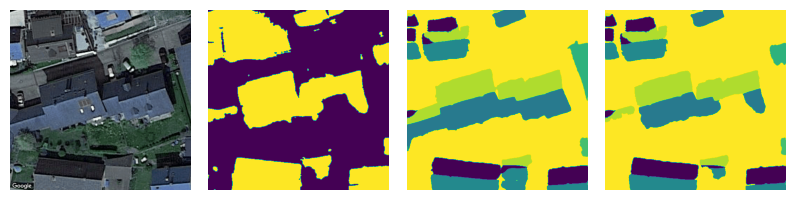

Processed image 1241, partial mean iou: 0.535764750737188, with background class: 0.558518817133417, mean angle difference: -24.284491822429906


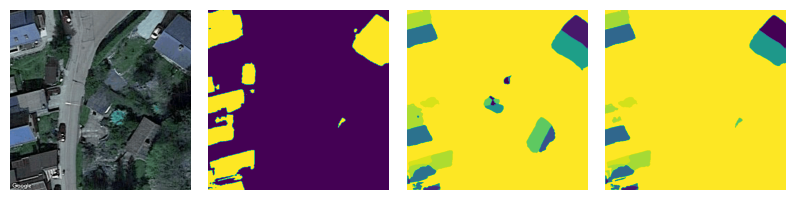

Processed image 1891, partial mean iou: 0.47464933907028334, with background class: 0.49836319795708217, mean angle difference: -16.456173421300658


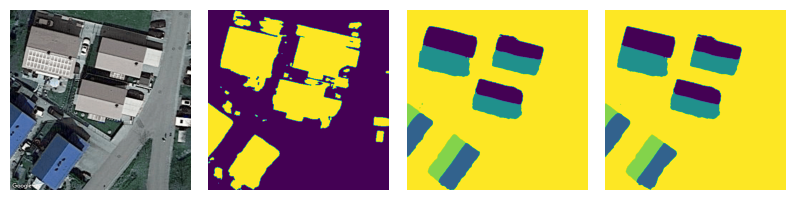

Processed image 302, partial mean iou: 0.5749280398457017, with background class: 0.5933551348218906, mean angle difference: -2.8742138364779874


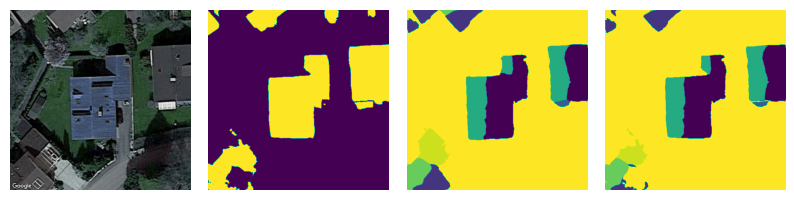

Processed image 475, partial mean iou: 0.5887824286866717, with background class: 0.6065296826917786, mean angle difference: -14.050410794928995


Elapsed time: 23.497750759124756 seconds
Final IoU per class: [0.76339066 0.79984954 0.62123805 0.64259233 0.74056621 0.
 0.64133255 0.63792975 0.71253719 0.72794544 0.72671329 0.55624994
 0.5870931  0.05585586 0.66217849 0.63143561 0.50239327 0.908233  ]
Final mean IoU with background class: 0.6065296826917786
Final mean IoU without background class: 0.5887824286866717
Final mean angle difference: -10.308082562560408
Mean IoU: 0.6065296826917786
Mean angle difference: -10.308082562560408 degrees
IoU per class: [0.76339066 0.79984954 0.62123805 0.64259233 0.74056621 0.
 0.64133255 0.63792975 0.71253719 0.72794544 0.72671329 0.55624994
 0.5870931  0.05585586 0.66217849 0.63143561 0.50239327 0.908233  ]
Elapsed time: 23.497750759124756 seconds.


In [24]:
iou, mean_iou, mad, elapsed_time = test_model_twolook(model_inria_final,
                                                       model_rid_final,
                                                       rid_test_folder,
                                                       num_classes,
                                                       background_class_1,
                                                       background_class_2,
                                                       ignore_index,
                                                       num_angles,
                                                       output=True)

print(f'Mean IoU: {mean_iou}')
print(f'Mean angle difference: {mad} degrees')
print(f'IoU per class: {iou}')
print(f'Elapsed time: {elapsed_time} seconds.')